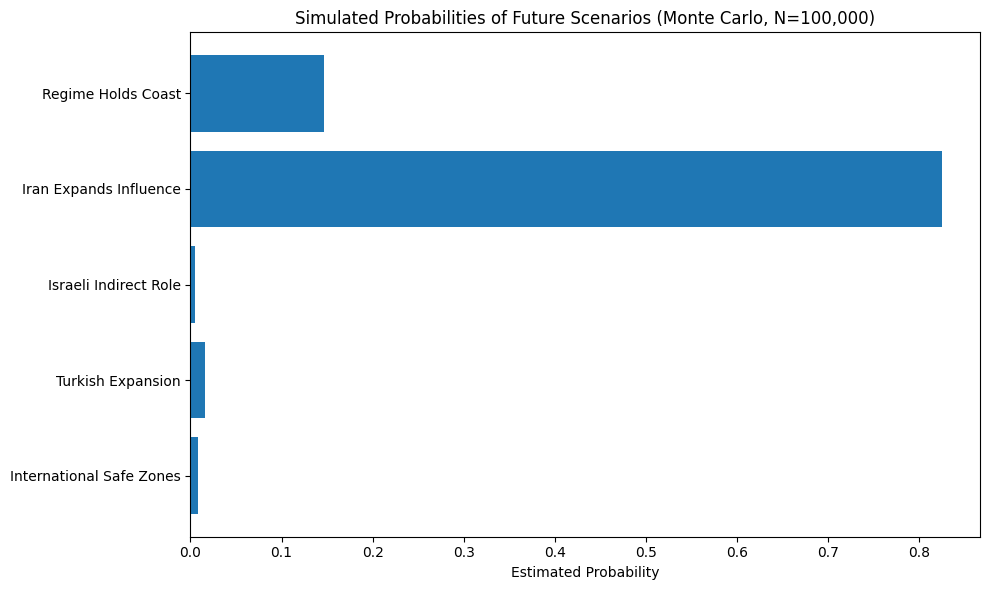

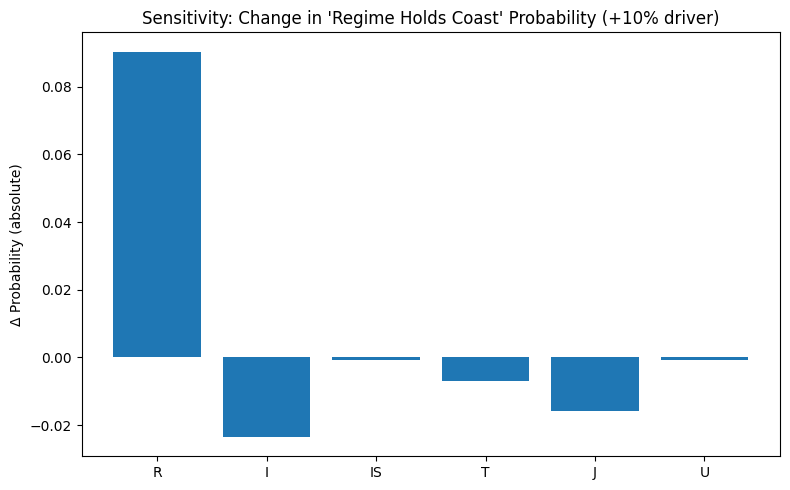

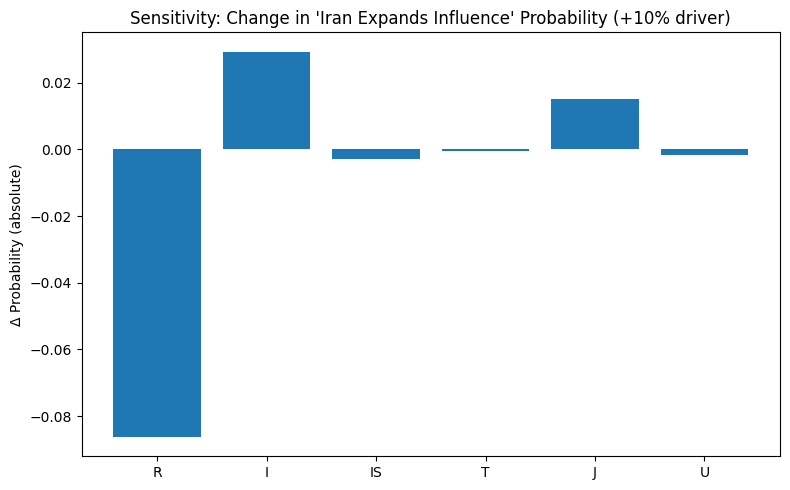

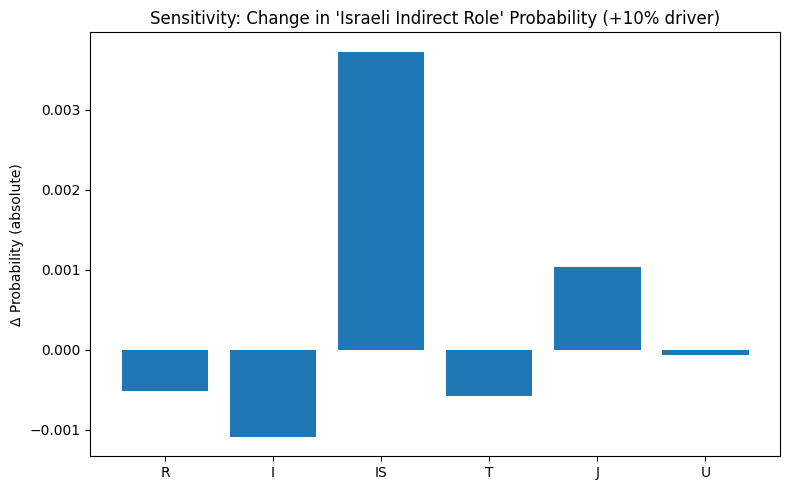

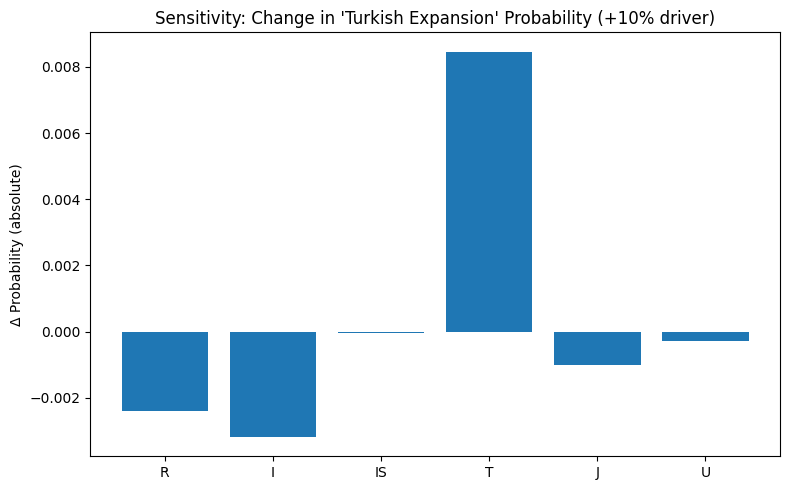

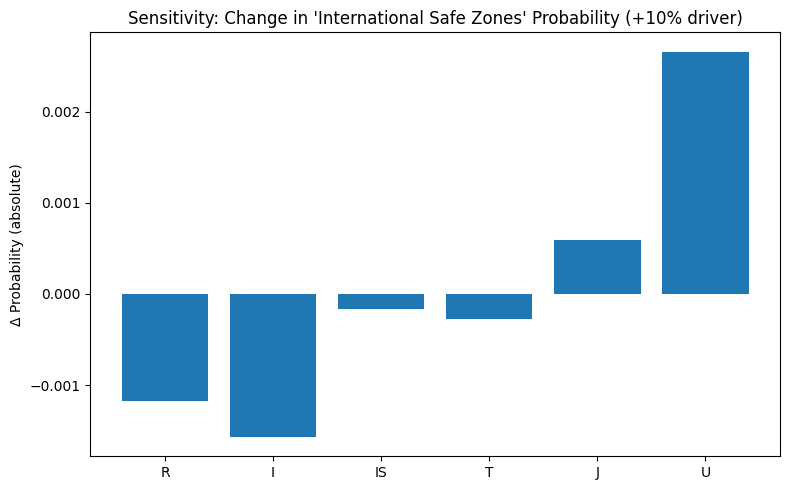

,Scenario,Estimated Probability
0,Regime Holds Coast,0.147
1,Iran Expands Influence,0.825
2,Israeli Indirect Role,0.005
3,Turkish Expansion,0.016
4,International Safe Zones,0.008


,Regime Holds Coast,Iran Expands Influence,Israeli Indirect Role,Turkish Expansion,International Safe Zones
R,0.0903,-0.0862,-0.0005,-0.0024,-0.0012
I,-0.0235,0.0293,-0.0011,-0.0032,-0.0016
IS,-0.0007,-0.0028,0.0037,-0.0000,-0.0002
T,-0.0070,-0.0006,-0.0006,0.0085,-0.0003
J,-0.0157,0.0151,0.0010,-0.0010,0.0006
U,-0.0006,-0.0017,-0.0001,-0.0003,0.0027


(WindowsPath('/mnt/data/syria_scenarios/scenario_probabilities.csv'),
 WindowsPath('/mnt/data/syria_scenarios/scenario_probabilities.png'),
 WindowsPath('/mnt/data/syria_scenarios/sensitivity_delta_probs.csv'),
 ['\\mnt\\data\\syria_scenarios\\sensitivity_regime_holds_coast.png',
  '\\mnt\\data\\syria_scenarios\\sensitivity_iran_expands_influence.png',
  '\\mnt\\data\\syria_scenarios\\sensitivity_israeli_indirect_role.png',
  '\\mnt\\data\\syria_scenarios\\sensitivity_turkish_expansion.png',
  '\\mnt\\data\\syria_scenarios\\sensitivity_international_safe_zones.png'],
 WindowsPath('/mnt/data/syria_scenarios/README_assumptions.txt'))

In [ ]:
# Developed using Python by Heider Jeffer
# Monte Carlo scenario analysis for Syria coastal protection outcomes
# (No internet access; this is a toy analytical model using synthetic assumptions.)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

np.random.seed(42)

# Number of simulations
N = 100_000

# Define scenarios
scenarios = [
    "Regime Holds Coast",
    "Iran Expands Influence",
    "Israeli Indirect Role",
    "Turkish Expansion",
    "International Safe Zones"
]

# Sample structural drivers (scaled 0-1) from Beta distributions
R = np.random.beta(4, 2, N)   # Russian commitment
I = np.random.beta(3, 2, N)   # Iranian capacity & willingness
IS = np.random.beta(2, 3, N)  # Israeli risk tolerance
T = np.random.beta(2, 3, N)   # Turkish intent & bandwidth to expand
J = np.random.beta(2, 2, N)   # Jihadist pressure in NW Syria
U = np.random.beta(1, 4, N)   # International appetite for safe zones / UN action

# Compute scenario "scores" as linear combinations
noise = np.random.normal(0, 0.05, (N, 5))

S_regime = 0.5*R + 0.2*I - 0.2*J - 0.1*T
S_iran    = 0.6*I + 0.3*(1 - R) + 0.1*J
S_israel  = 0.4*IS + 0.2*J + 0.2*I - 0.2*T - 0.2*R
S_turkey  = 0.5*T + 0.2*(1 - R) - 0.2*I - 0.1*J
S_safe    = 0.4*U + 0.2*(1 - R) + 0.1*J - 0.1*I

scores = np.vstack([S_regime, S_iran, S_israel, S_turkey, S_safe]).T + noise

# Choose scenario with highest score per simulation
winners_idx = np.argmax(scores, axis=1)
winners = np.array(scenarios)[winners_idx]

# Aggregate probabilities
probs = pd.Series(winners).value_counts(normalize=True).reindex(scenarios).fillna(0)
probs_df = probs.reset_index()
probs_df.columns = ["Scenario", "Estimated Probability"]
probs_df["Estimated Probability"] = probs_df["Estimated Probability"].round(3)

# Save to CSV
out_dir = Path("/mnt/data/syria_scenarios")
out_dir.mkdir(parents=True, exist_ok=True)
csv_path = out_dir / "scenario_probabilities.csv"
probs_df.to_csv(csv_path, index=False)

# Plot probability bar chart
plt.figure(figsize=(10, 6))
plt.barh(probs.index, probs.values)
plt.xlabel("Estimated Probability")
plt.title("Simulated Probabilities of Future Scenarios (Monte Carlo, N=100,000)")
plt.gca().invert_yaxis()
plt.tight_layout()
prob_png = out_dir / "scenario_probabilities.png"
plt.savefig(prob_png)
plt.show()

# SIMPLE one-factor sensitivity: vary each driver by +10%, recompute probabilities
def recompute_with_scaling(var_name):
    vars_scaled = {"R": R.copy(), "I": I.copy(), "IS": IS.copy(),
                   "T": T.copy(), "J": J.copy(), "U": U.copy()}
    arr = vars_scaled[var_name]
    arr = np.clip(arr * 1.1, 0, 1)
    vars_scaled[var_name] = arr
    
    S_regime2 = 0.5*vars_scaled["R"] + 0.2*vars_scaled["I"] - 0.2*vars_scaled["J"] - 0.1*vars_scaled["T"]
    S_iran2   = 0.6*vars_scaled["I"] + 0.3*(1 - vars_scaled["R"]) + 0.1*vars_scaled["J"]
    S_israel2 = 0.4*vars_scaled["IS"] + 0.2*vars_scaled["J"] + 0.2*vars_scaled["I"] - 0.2*vars_scaled["T"] - 0.2*vars_scaled["R"]
    S_turkey2 = 0.5*vars_scaled["T"] + 0.2*(1 - vars_scaled["R"]) - 0.2*vars_scaled["I"] - 0.1*vars_scaled["J"]
    S_safe2   = 0.4*vars_scaled["U"] + 0.2*(1 - vars_scaled["R"]) + 0.1*vars_scaled["J"] - 0.1*vars_scaled["I"]
    
    scores2 = np.vstack([S_regime2, S_iran2, S_israel2, S_turkey2, S_safe2]).T + noise
    winners2 = np.argmax(scores2, axis=1)
    probs2 = pd.Series(np.array(scenarios)[winners2]).value_counts(normalize=True).reindex(scenarios).fillna(0)
    return probs2

drivers = ["R","I","IS","T","J","U"]
sens = {d: recompute_with_scaling(d) - probs for d in drivers}
sens_df = pd.DataFrame(sens).T
sens_df.columns = scenarios
sens_csv = out_dir / "sensitivity_delta_probs.csv"
sens_df.to_csv(sens_csv)

# Plot sensitivity for each scenario
sensitivity_pngs = []
for scen in scenarios:
    plt.figure(figsize=(8, 5))
    delta = sens_df[scen]
    plt.bar(drivers, delta.values)
    plt.ylabel("Δ Probability (absolute)")
    plt.title(f"Sensitivity: Change in '{scen}' Probability (+10% driver)")
    plt.tight_layout()
    outp = out_dir / f"sensitivity_{scen.replace(' ', '_').lower()}.png"
    plt.savefig(outp)
    sensitivity_pngs.append(outp)
    plt.show()

# Save README-style assumptions
readme_path = out_dir / "README_assumptions.txt"
readme_text = """Toy Monte Carlo model (no internet access)

Scenarios:
1) Regime Holds Coast
2) Iran Expands Influence
3) Israeli Indirect Role
4) Turkish Expansion
5) International Safe Zones

Drivers (0-1):
R = Russian commitment (Beta(4,2))
I = Iranian capacity & willingness (Beta(3,2))
IS = Israeli risk tolerance for covert involvement (Beta(2,3))
T = Turkish intent & bandwidth (Beta(2,3))
J = Jihadist pressure in NW Syria (Beta(2,2))
U = International appetite for safe zones (Beta(1,4))

Linear score assumptions documented in the notebook.
Sensitivity: +10% change per driver, clipping to [0,1], holding others fixed.
"""
with open(readme_path, "w") as f:
    f.write(readme_text)

# Display results in notebook
display(probs_df)
display(sens_df.round(4))

# Return paths of saved files
csv_path, prob_png, sens_csv, [str(p) for p in sensitivity_pngs], readme_path
